In [21]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mutual_info_score
from statsmodels.tsa.seasonal import seasonal_decompose  

In [22]:
# Função de denoising com wavelet
def wavelet_denoising(signal, wavelet='sym18', level=2):
    coeffs = pywt.wavedec(signal, wavelet, mode='periodization', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='periodization')
    return reconstructed_signal[:len(signal)]

# Função para encontrar a melhor janela de previsão baseada no ACF
def best_prediction_window(signal, max_lag=288):
    max_lag = min(len(signal) - 1, max_lag)
    acf_values = acf(signal, nlags=max_lag, fft=False)
    threshold = 1 / np.e
    diffs = acf_values - threshold
    crossings = np.where((diffs[:-1] > 0) & (diffs[1:] <= 0))[0]
    return crossings, acf_values

# Função para calcular a Average Mutual Information (AMI)
def calculate_ami(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Função para encontrar todos os mínimos locais na curva de AMI
def find_all_minimums_ami(ami_values):
    minima = []
    for i in range(1, len(ami_values)-1):
        if ami_values[i] < ami_values[i-1] and ami_values[i] < ami_values[i+1]:
            minima.append(i+1)  # +1 para ajustar o índice devido ao lag iniciar em 1
    return minima

# Função para determinar os lags usando AMI
def select_lags_ami(signal, max_lag=288, bins=20):
    ami_values = [calculate_ami(signal[:-lag], signal[lag:]) for lag in range(1, max_lag+1)]
    minima = find_all_minimums_ami(ami_values)
    maxima = []  # Inicialização para evitar erro, caso seja necessária
    return minima, maxima, ami_values

# Função para criar features de rolling
def create_rolling_features(df, windows):
    df_rolled = pd.DataFrame(index=df.index)
    for window_name, window_size in windows.items():
        for col in df.columns:
            df_rolled[f'{col}_rolling_mean_{window_name}'] = df[col].rolling(window=window_size, min_periods=1).mean()
    return df_rolled


In [23]:

# Leitura dos dados
data = pd.read_csv("dataset.csv")

# Processamento inicial dos dados
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0])
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce')
data.set_index('id_datetime', inplace=True)
data.drop(columns=['id_str'], inplace=True)
variables = pd.DataFrame(index=data.index)


Correlação das variáveis com 'ws100':
year                NaN
month         -0.209302
day           -0.099138
hour           0.027247
minute        -0.009205
                 ...   
vertdisp190    0.265527
vertdisp200    0.258682
vertdisp220    0.246761
vertdisp240    0.237659
vertdisp260    0.228765
Name: ws100, Length: 107, dtype: float64

Correlações filtradas (|correlação| > 1/e):
humid        -0.433935
wdisp40       0.671055
wdisp50       0.654558
wdisp60       0.635030
wdisp70       0.614828
wdisp80       0.595994
wdisp90       0.577574
wdisp100      0.558741
wdisp110      0.539850
wdisp120      0.521773
wdisp130      0.502699
wdisp140      0.483278
wdisp150      0.465046
wdisp160      0.448319
wdisp170      0.432731
wdisp180      0.416633
wdisp190      0.400466
wdisp200      0.385741
vertdisp40    0.491436
vertdisp50    0.477266
vertdisp60    0.447528
vertdisp70    0.422799
vertdisp80    0.400473
vertdisp90    0.382295
Name: ws100, dtype: float64


/tmp/ipykernel_68698/3079264671.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm')


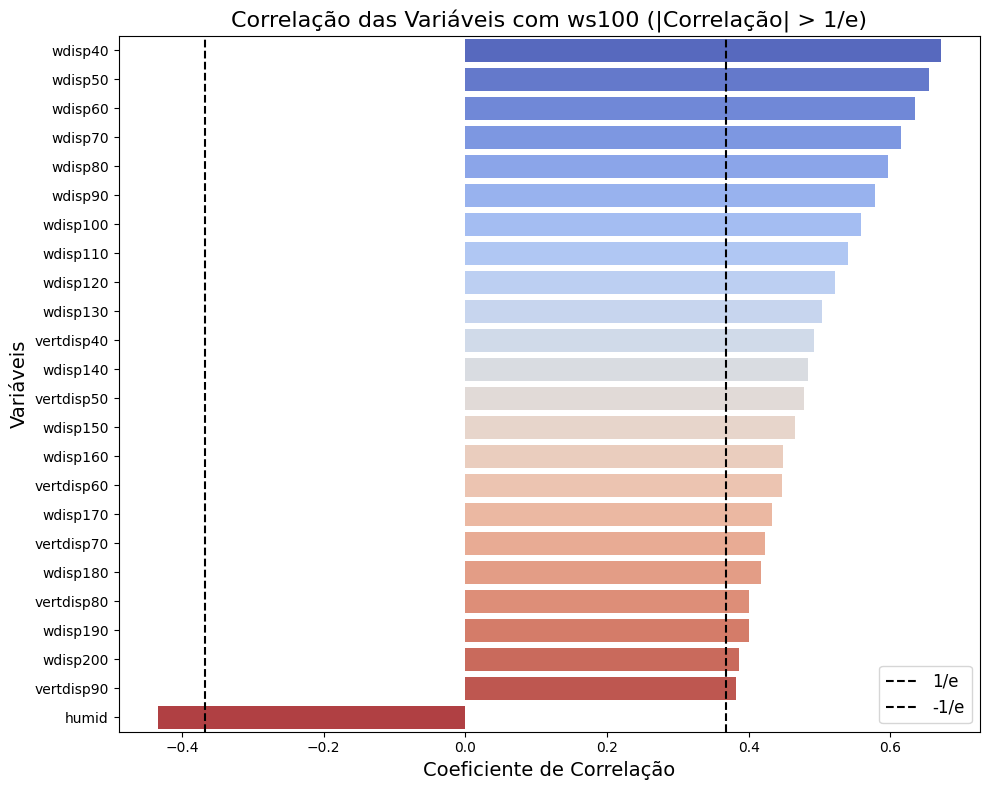

In [34]:
dados_numericos = data.select_dtypes(include=['number'])

# Verifica se 'ws100' está presente nas colunas numéricas
if 'ws100' not in dados_numericos.columns:
    raise ValueError("A coluna 'ws100' não foi encontrada nas colunas numéricas do DataFrame.")

# Identifica colunas que contêm 'ws' no nome (para remover 'ws100' e outras similares)
ws_columns = dados_numericos.filter(like='ws').columns

# Calcula a correlação de todas as variáveis com 'ws100'
# Remove as colunas que contêm 'ws' no nome para evitar autocorrelação ou correlação indesejada
correlacoes_ws100 = dados_numericos.corr()['ws100'].drop(ws_columns)
print("Correlação das variáveis com 'ws100':")
print(correlacoes_ws100)

# Definição do valor de 1/e
um_sobre_e = 1 / np.e  # Aproximadamente 0.36787944117

# Filtra as correlações que são maiores que 1/e ou menores que -1/e
correlacoes_filtradas = correlacoes_ws100[
    (correlacoes_ws100 > um_sobre_e) | (correlacoes_ws100 < -um_sobre_e)
]
print("\nCorrelações filtradas (|correlação| > 1/e):")
print(correlacoes_filtradas)

# Verifica se há variáveis que atendem ao critério
if correlacoes_filtradas.empty:
    print("\nNenhuma variável possui correlação com 'ws100' maior que 1/e ou menor que -1/e.")
else:
    # Define o tamanho da figura (largura, altura) mais compacto
    plt.figure(figsize=(10, 8))  # Ajuste conforme necessário
    
    # Ordena as correlações filtradas para melhor visualização
    correlacoes_ordenadas = correlacoes_filtradas.sort_values(ascending=False)
    
    # Cria o gráfico de barras apenas com as correlações filtradas
    sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm')
    
    # Adiciona título e rótulos com tamanhos de fonte ajustados
    plt.title('Correlação das Variáveis com ws100 (|Correlação| > 1/e)', fontsize=16)
    plt.xlabel('Coeficiente de Correlação', fontsize=14)
    plt.ylabel('Variáveis', fontsize=14)
    
    # Adiciona as linhas verticais em 1/e e -1/e
    plt.axvline(x=um_sobre_e, color='black', linestyle='--', label='1/e')
    plt.axvline(x=-um_sobre_e, color='black', linestyle='--', label='-1/e')
    
    # Opcional: Adiciona legenda para as linhas verticais
    plt.legend(fontsize=12)
    
    # Ajusta o layout para melhor aproveitamento do espaço
    plt.tight_layout()
    
    # Exibe o gráfico
    plt.show()

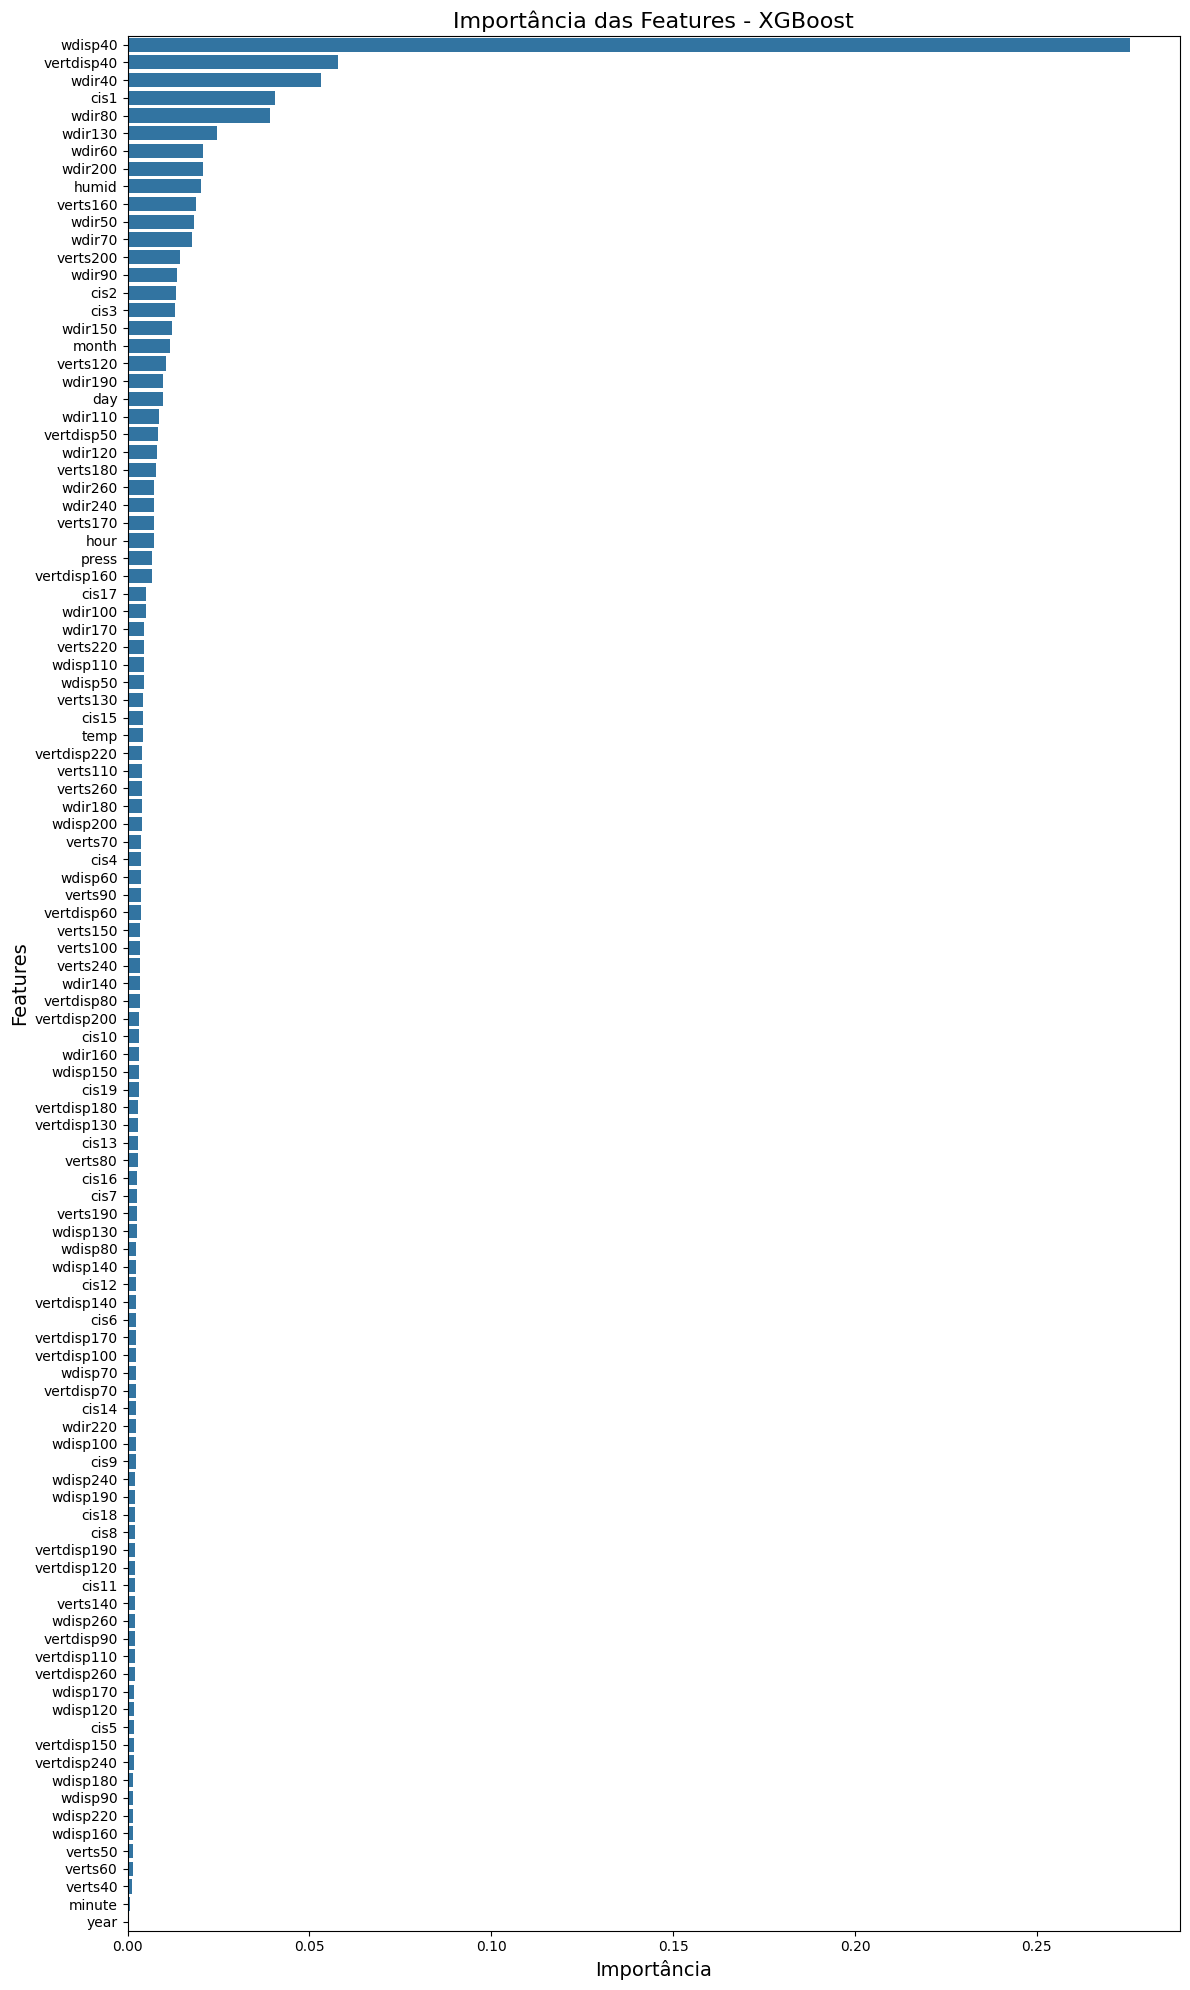

In [25]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

ws_columns = dados_numericos.filter(like='ws').columns
X = dados_numericos.drop(columns=ws_columns, axis=1)
y = dados_numericos['ws100']

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

features = X.columns

# Inicializa e treina o modelo XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgbr.fit(X_train, y_train)

# Obtém a importância das features
importancias_xgb = xgbr.feature_importances_
df_importancias_xgb = pd.DataFrame({'Feature': features, 'Importância': importancias_xgb})
df_importancias_xgb = df_importancias_xgb.sort_values(by='Importância', ascending=False)

# Visualiza as importâncias
plt.figure(figsize=(12, 20))
sns.barplot(x='Importância', y='Feature', data=df_importancias_xgb)
plt.title('Importância das Features - XGBoost', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

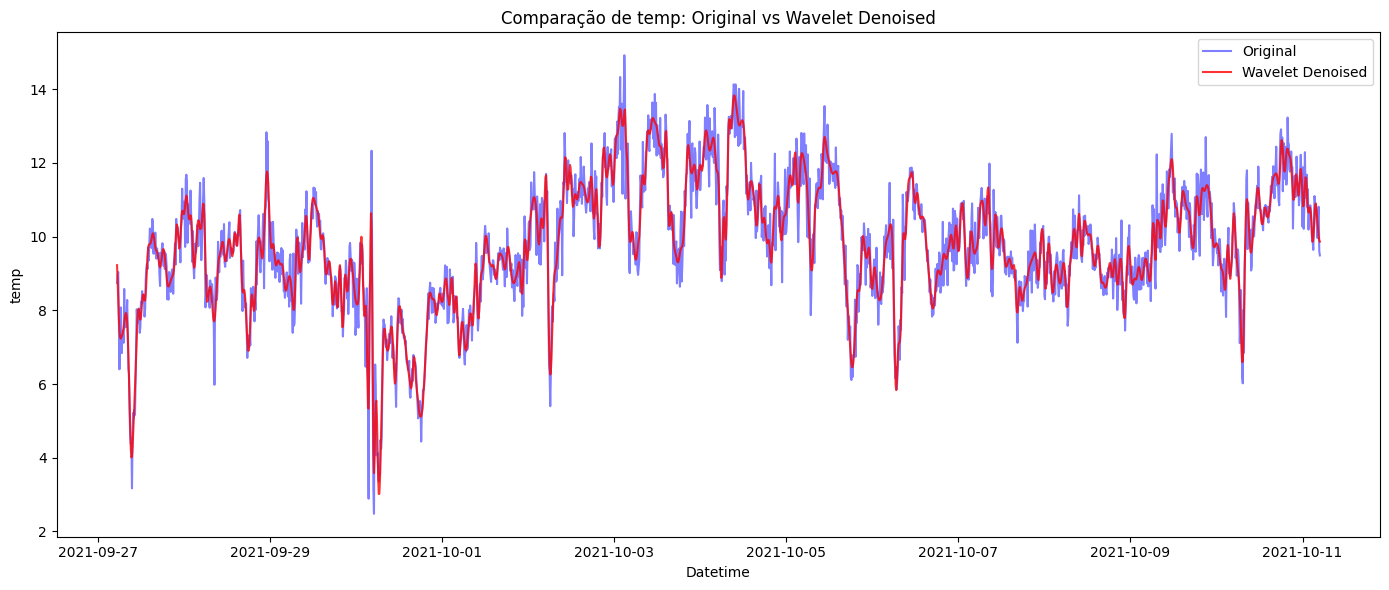

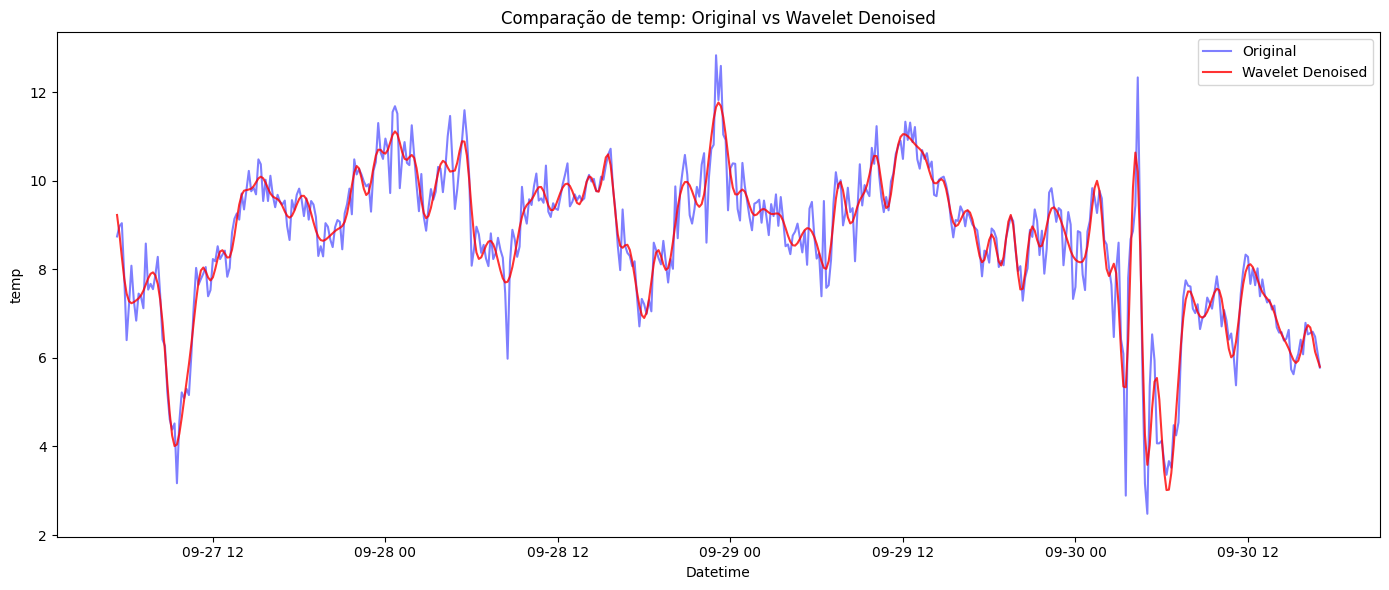

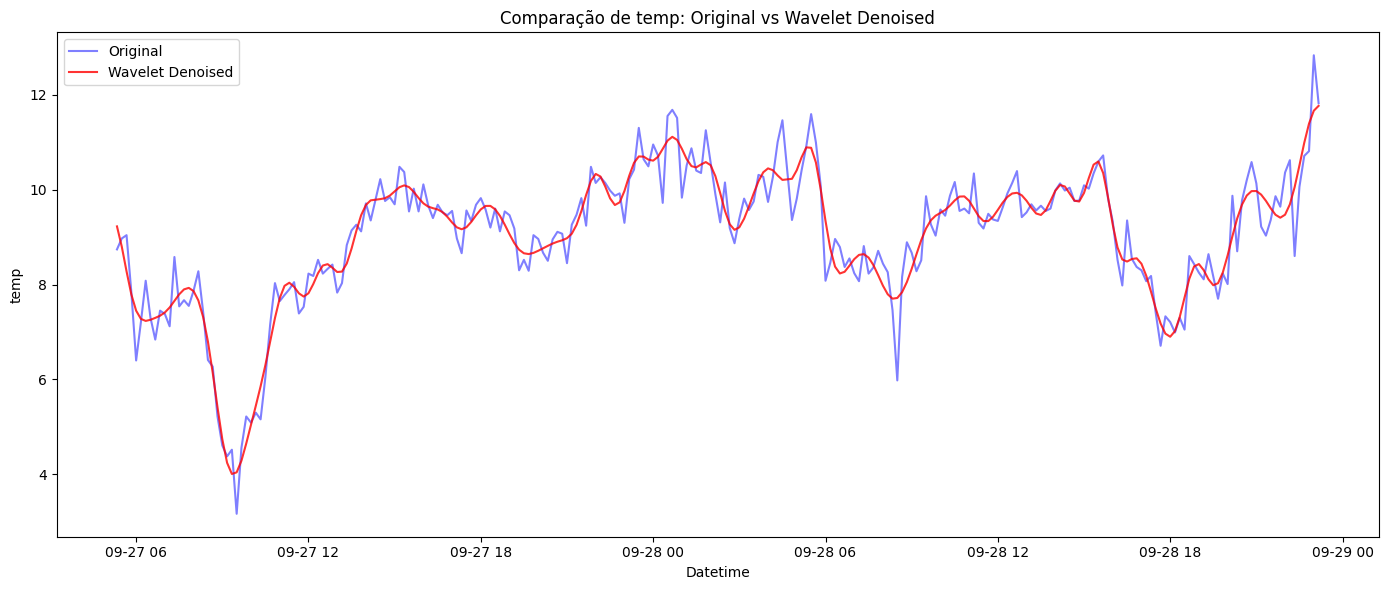

In [26]:
# Lista de colunas a serem denoizadas
columns_to_denoise = ['ws100', 'wdisp40', 'vertdisp40', 'wdir40', 'cis1', 'humid', 'temp']

# Denoising e armazenamento das variáveis
for col in columns_to_denoise:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal
    else:
        raise ValueError(f"A coluna '{col}' não existe no conjunto de dados.")
    
# Gráficos comparativo da curva original e denoised
plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:3500], data['ws100'][1500:3500], label='Original', alpha=0.5, color= 'blue')
plt.plot(variables.index[1500:3500], variables['ws100_wavelet'][1500:3500], label='Wavelet Denoised', alpha=0.8, color = 'red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:2000], data['ws100'][1500:2000], label='Original', alpha=0.5, color= 'blue')
plt.plot(variables.index[1500:2000], variables['ws100_wavelet'][1500:2000], label='Wavelet Denoised', alpha=0.8, color = 'red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:1750], data['ws100'][1500:1750], label='Original', alpha=0.5, color= 'blue')
plt.plot(variables.index[1500:1750], variables['ws100_wavelet'][1500:1750], label='Wavelet Denoised', alpha=0.8, color = 'red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()



In [27]:
# Função para criar features de rolling
def create_rolling_features(df, windows):
    df_rolled = pd.DataFrame(index=df.index)
    for window_name, window_size in windows.items():
        for col in df.columns:
            df_rolled[f'{col}_rolling_mean_{window_name}'] = df[col].rolling(window=window_size, min_periods=1).mean()
    return df_rolled

windows = {
    'daily': 144
}

rolling_features = create_rolling_features(variables, windows)


In [28]:

# Seleção de lags para cada variável usando AMI
lags_selected = {}
for col in variables.columns:
    signal = variables[col].dropna()
    minima, maxima, ami_values = select_lags_ami(signal, max_lag=288, bins=20)
    print(f"Mínima: Lag selecionado usando AMI para {col}: {minima}")


Mínima: Lag selecionado usando AMI para ws100_wavelet: [33, 39, 46, 49, 57, 90, 102, 105, 108, 112, 119, 176, 186, 188, 192, 198, 200, 202, 208, 214, 226, 231, 234, 238, 242, 249, 255, 258, 262, 270, 281, 285, 287]
Mínima: Lag selecionado usando AMI para wdisp40_wavelet: [51, 58, 65, 70, 73, 77, 83, 85, 88, 91, 93, 98, 101, 105, 107, 182, 187, 189, 198, 201, 204, 207, 215, 217, 222, 227, 232, 238, 243, 246, 251, 257, 259]
Mínima: Lag selecionado usando AMI para vertdisp40_wavelet: [34, 44, 53, 55, 59, 69, 84, 111, 174, 177, 200, 214, 222, 228, 254]
Mínima: Lag selecionado usando AMI para wdir40_wavelet: [42, 46, 65, 67, 77, 86, 88, 108, 143, 175, 178, 189, 207, 209, 213, 216, 224, 256]
Mínima: Lag selecionado usando AMI para cis1_wavelet: [39, 71, 106, 177, 180, 250]
Mínima: Lag selecionado usando AMI para humid_wavelet: [37, 70, 77, 108, 176, 209, 211, 214, 217, 253]
Mínima: Lag selecionado usando AMI para temp_wavelet: [31, 72, 110, 176, 214, 253]


A melhor janela de previsão para ws100_wavelet com ACF são [ 90 158].


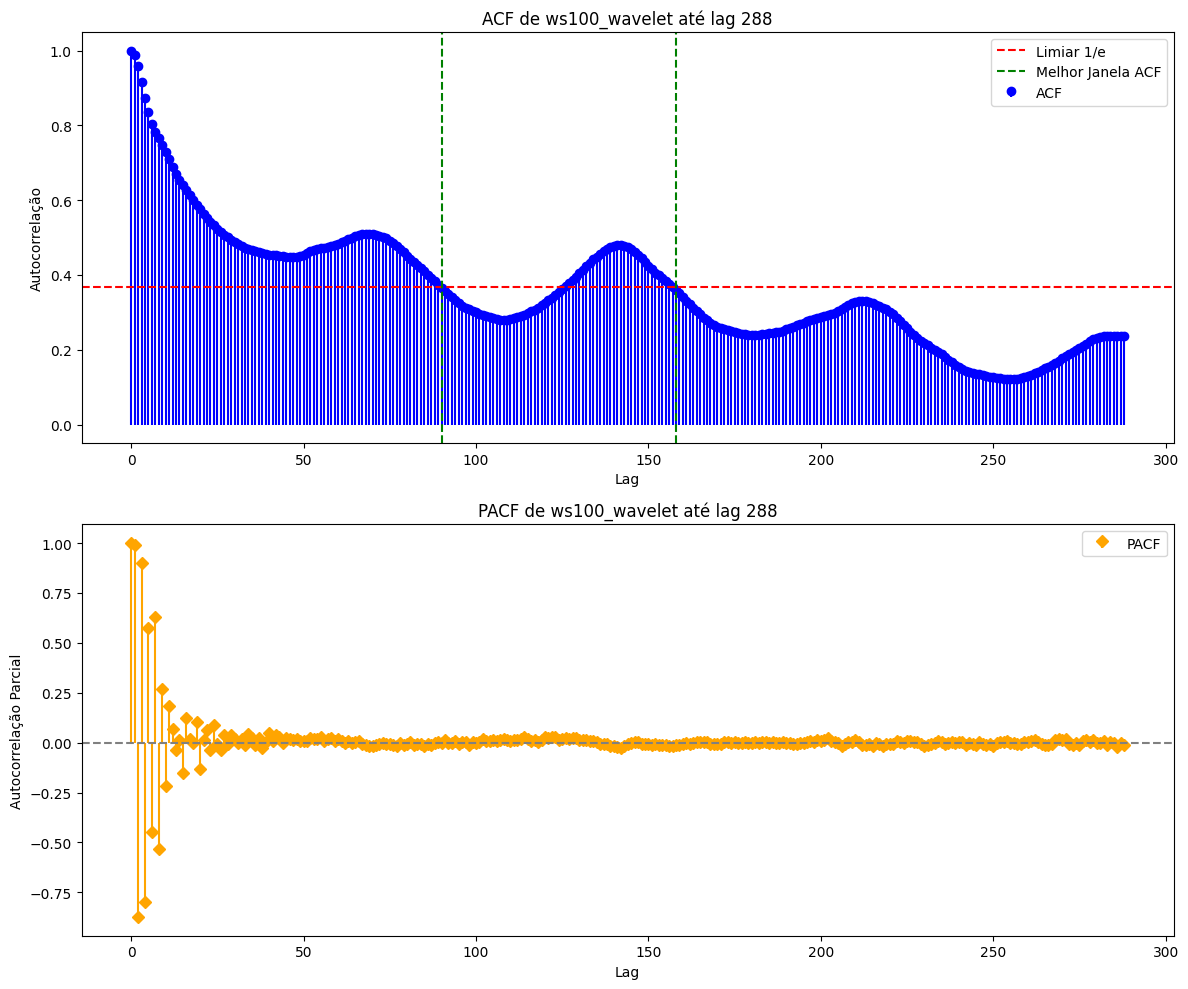

A melhor janela de previsão para wdisp40_wavelet com ACF são [ 30 165].


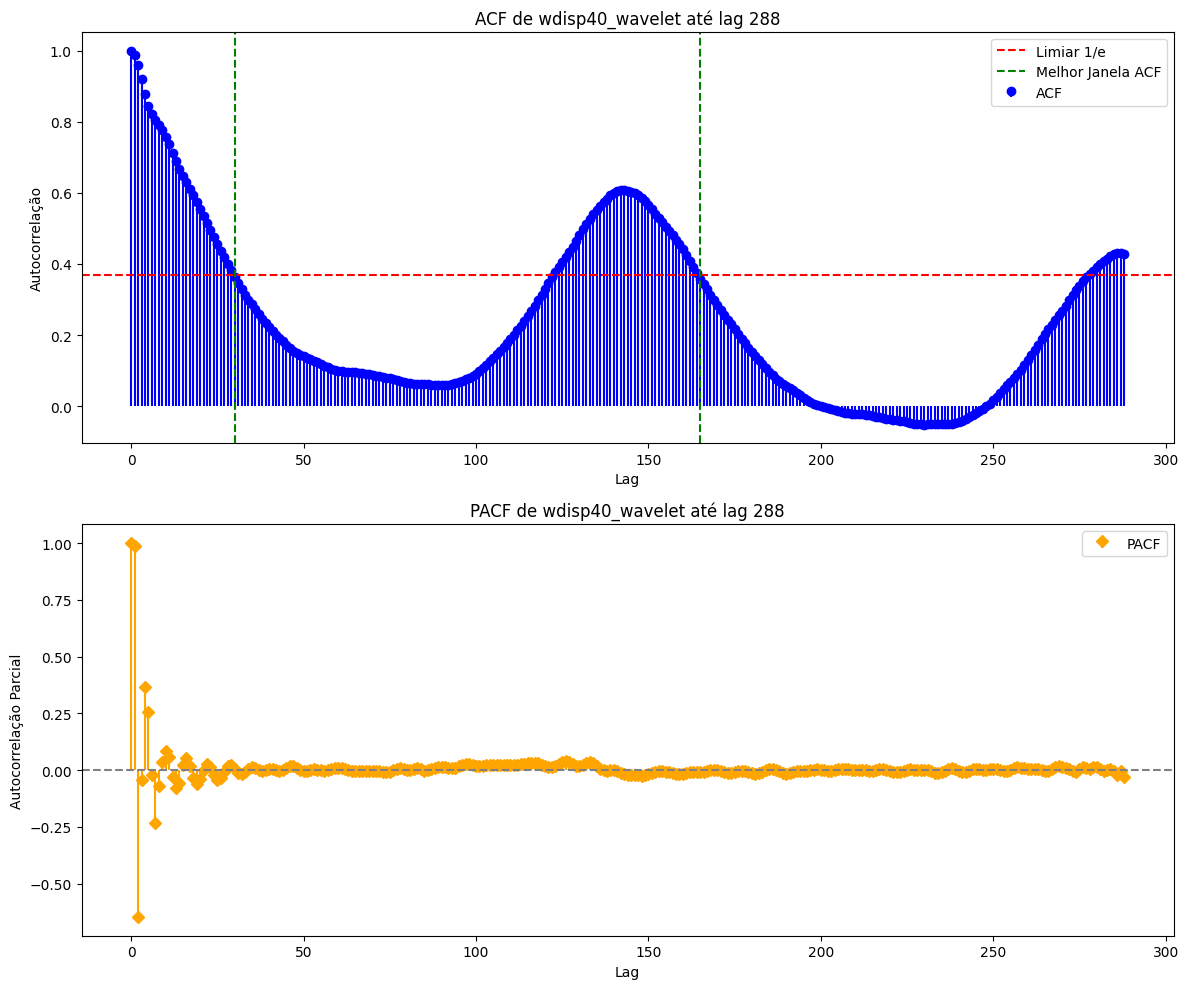

A melhor janela de previsão para vertdisp40_wavelet com ACF são [ 24 165].


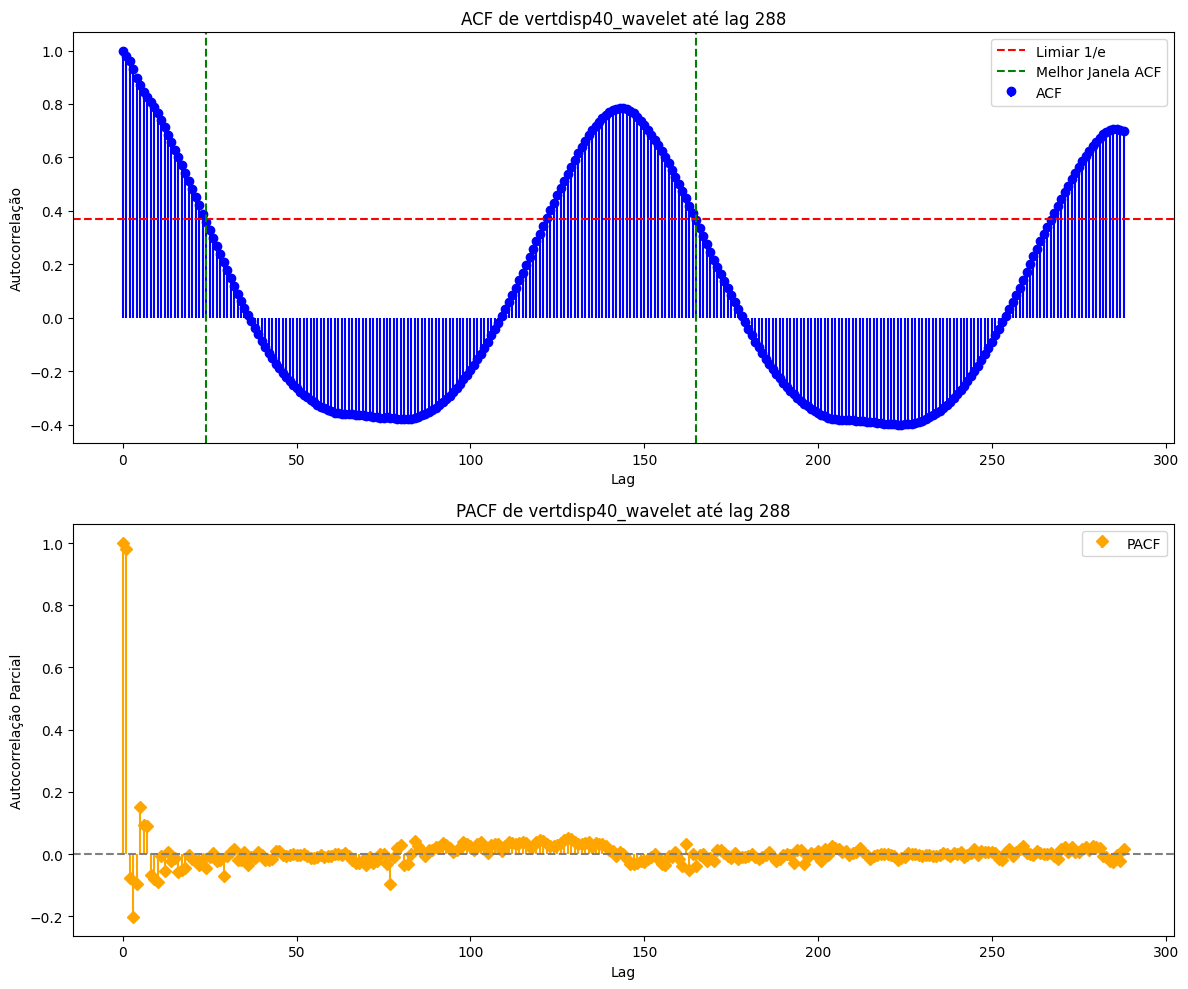

A melhor janela de previsão para wdir40_wavelet com ACF são [ 20 148].


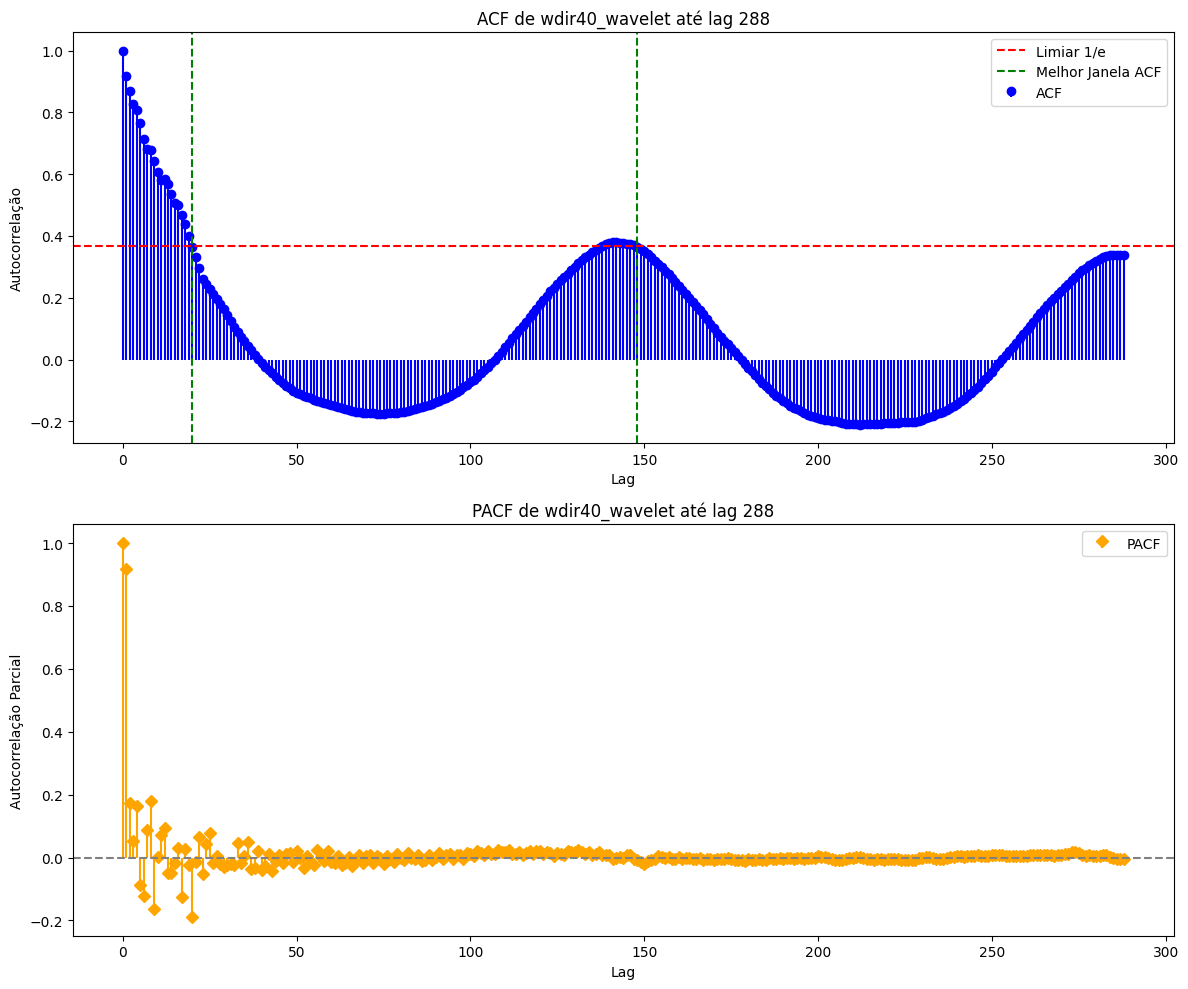

A melhor janela de previsão para cis1_wavelet com ACF são [ 25 167].


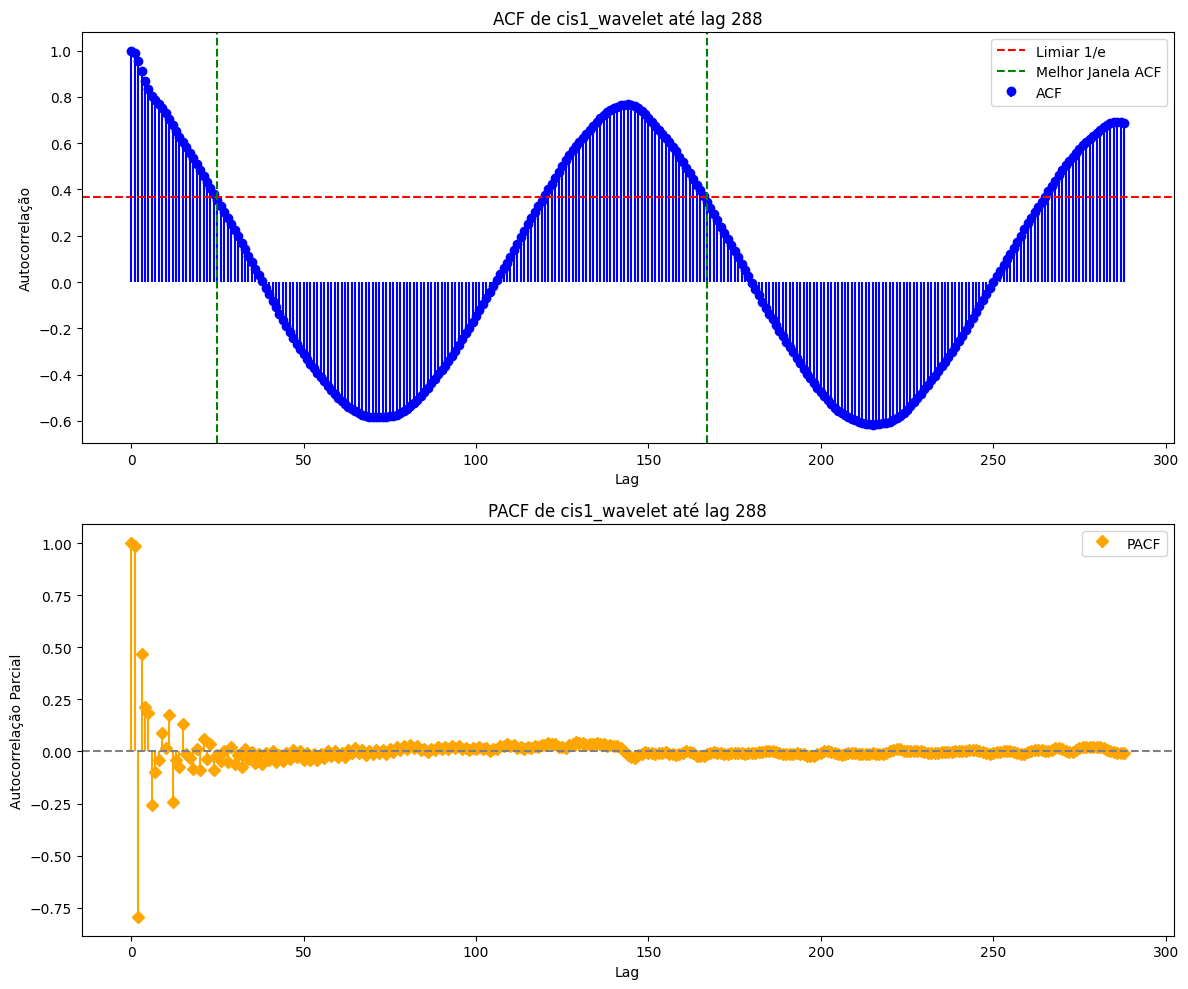

A melhor janela de previsão para humid_wavelet com ACF são [ 25 165].


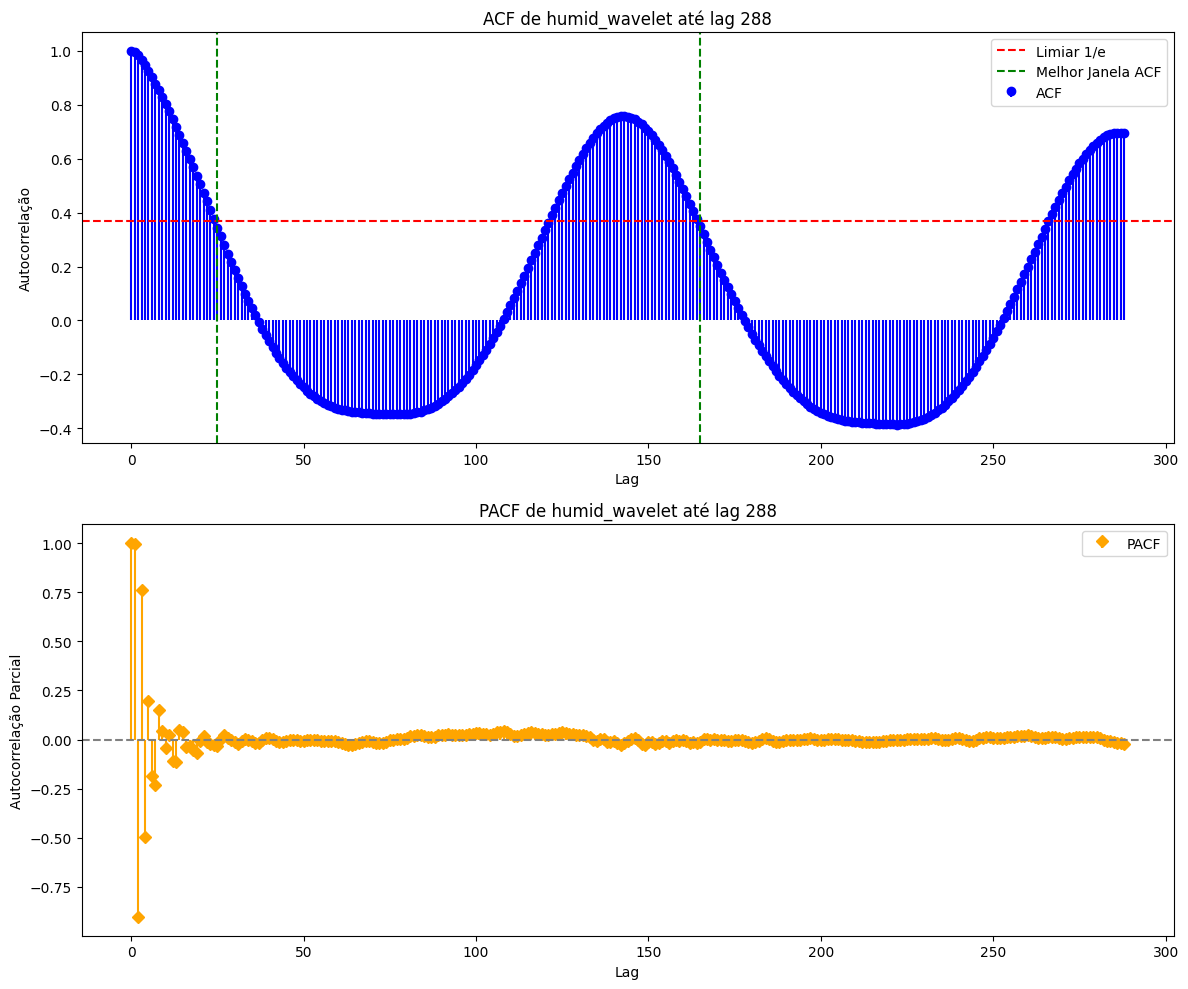

A melhor janela de previsão para temp_wavelet com ACF são [ 23 165].


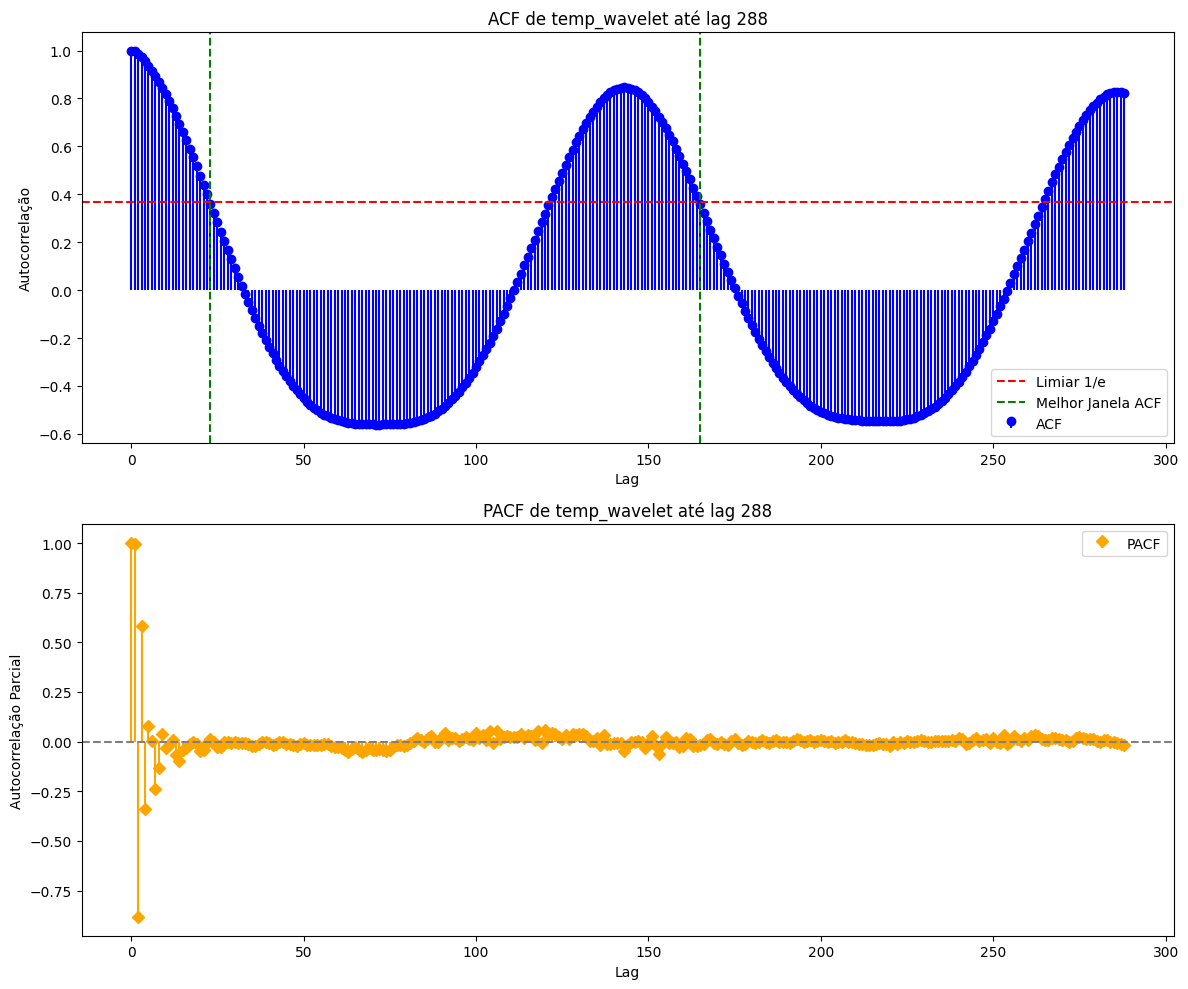

In [29]:

# Cálculo de ACF e PACF e plotagem
for col in variables.columns:
    signal = variables[col].dropna()
    best_windows, acf_values = best_prediction_window(signal, max_lag=288)
    pacf_values = pacf(signal, nlags=288, method='ols')  # Calculando PACF

    print(f"A melhor janela de previsão para {col} com ACF são {best_windows + 1}.")

    # Configurando os subplots para ACF e PACF
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot do ACF
    axes[0].stem(range(len(acf_values)), acf_values, linefmt='b-', markerfmt='bo', basefmt=" ", label='ACF')
    axes[0].axhline(y=1 / np.e, color='red', linestyle='--', label='Limiar 1/e')

    # Plotando todas as linhas verticais para cada crossing
    for idx, window in enumerate(best_windows + 1):
        if idx == 0:
            axes[0].axvline(x=window, color='green', linestyle='--', label='Melhor Janela ACF')
        else:
            axes[0].axvline(x=window, color='green', linestyle='--')

    axes[0].set_title(f'ACF de {col} até lag {288}')
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelação')
    axes[0].legend()

    # Plot da PACF
    axes[1].stem(range(len(pacf_values)), pacf_values, linefmt='orange', markerfmt='D', basefmt=" ", label='PACF')
    axes[1].axhline(y=0, color='gray', linestyle='--')
    axes[1].set_title(f'PACF de {col} até lag {288}')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Autocorrelação Parcial')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [30]:
variables_engineered = pd.concat([variables, rolling_features], axis=1)

variables_engineered['hour'] = variables_engineered.index.hour


variables_engineered['temp_humid_product'] = (
    variables_engineered['temp_wavelet'] * 
    variables_engineered['humid_wavelet']
)

variables_engineered.drop(columns=['humid_wavelet'], inplace=True)

variables_engineered.head()


,ws100_wavelet,wdisp40_wavelet,vertdisp40_wavelet,wdir40_wavelet,cis1_wavelet,temp_wavelet,ws100_wavelet_rolling_mean_daily,wdisp40_wavelet_rolling_mean_daily,vertdisp40_wavelet_rolling_mean_daily,wdir40_wavelet_rolling_mean_daily,cis1_wavelet_rolling_mean_daily,humid_wavelet_rolling_mean_daily,temp_wavelet_rolling_mean_daily,hour,temp_humid_product
id_datetime,,,,,,,,,,,,,,,
2021-09-16 18:00:00,8.983404,1.125007,0.541001,43.763171,0.017565,28.188888,8.983404,1.125007,0.541001,43.763171,0.017565,73.362584,28.188888,18,2068.009641
2021-09-16 18:10:00,8.849366,1.062998,0.417626,49.089948,0.023208,27.757578,8.916385,1.094003,0.479313,46.426560,0.020387,75.050151,27.973233,18,2130.053202
2021-09-16 18:19:59,8.848879,1.037261,0.392122,52.272865,0.025629,27.350217,8.893883,1.075089,0.450250,48.375328,0.022134,76.294321,27.765561,18,2154.722836
2021-09-16 18:30:00,8.952212,1.030244,0.425655,53.863347,0.025714,27.535623,8.908465,1.063877,0.444101,49.747333,0.023029,76.974263,27.708076,18,2175.702217
2021-09-16 18:39:59,9.060865,1.005019,0.435672,55.829615,0.026039,27.489673,8.938945,1.052106,0.442415,50.963789,0.023631,77.476891,27.664396,18,2185.082681


In [31]:
# Histograma e KDE para cada variável
# for col in variables_engineered.columns:
#     plt.figure(figsize=(14, 6))
#     sns.histplot(variables_engineered[col], kde=True, bins=30, color='skyblue')
#     plt.title(f'Distribuição de {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequência')
#     plt.tight_layout()
#     plt.show()


In [32]:
from statsmodels.tsa.stattools import ccf

# Correlação Cruzada entre 'ws100_wavelet' e outras variáveis
target_col = 'ws100_wavelet'
# for col in variables_engineered.columns:
#     if col != target_col:
#         correlation = ccf(variables_engineered[target_col], variables_engineered[col])[:288]  # Lag até 50
#         plt.figure(figsize=(14, 6))
#         plt.stem(range(len(correlation)), correlation)
#         plt.title(f'Correlação Cruzada entre {target_col} e {col}')
#         plt.xlabel('Lag')
#         plt.ylabel('Correlação Cruzada')
#         plt.tight_layout()
#         plt.show()


In [36]:
# Carregue seu DataFrame (ajuste o caminho conforme necessário)
# Por exemplo, se já estiver em memória, você pode ignorar esta etapa
# variables_engineered = pd.read_csv('seu_arquivo.csv', index_col=0)

# Verifica se 'ws100_wavelet' está presente nas colunas numéricas
if 'ws100_wavelet' not in variables_engineered.columns:
    raise ValueError("A coluna 'ws100_wavelet' não existe no DataFrame.")

# Define as features (X) e a variável alvo (y)
X = variables_engineered.drop('ws100_wavelet', axis=1)
y = variables_engineered['ws100_wavelet']


Mean Squared Error no conjunto de teste: 1.6923

Top 10 Features selecionadas pelo XGBoost:
['wdisp40_wavelet', 'ws100_wavelet_rolling_mean_daily', 'cis1_wavelet_rolling_mean_daily', 'humid_wavelet_rolling_mean_daily', 'temp_humid_product', 'wdir40_wavelet_rolling_mean_daily', 'vertdisp40_wavelet', 'wdisp40_wavelet_rolling_mean_daily', 'vertdisp40_wavelet_rolling_mean_daily']


/tmp/ipykernel_68698/3181299273.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')


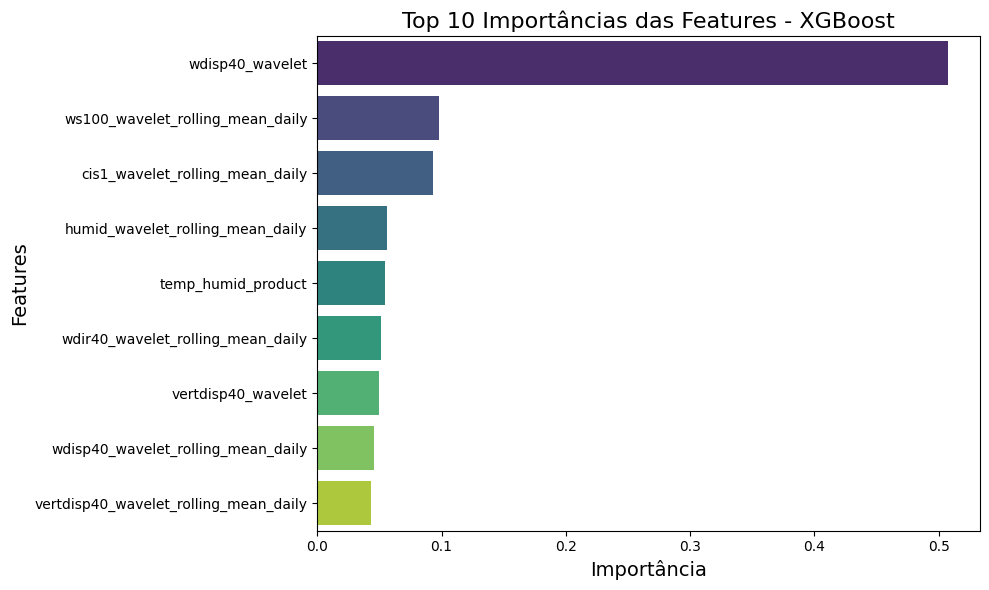

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para modelagem
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Para seleção das top features
import xgboost as xgb

# Divisão dos dados em treino e teste para avaliar o modelo posteriormente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Inicializa o modelo XGBoost para regressão
model = XGBRegressor(
    objective='reg:squarederror',  # Para regressão
    n_estimators=100,              # Número de árvores
    learning_rate=0.1,             # Taxa de aprendizado
    max_depth=5,                   # Profundidade máxima das árvores
    random_state=42,
    n_jobs=-1                       # Utiliza todos os núcleos disponíveis
)

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliação do modelo (opcional)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error no conjunto de teste: {mse:.4f}")

# Obtém as importâncias das features
importances = model.feature_importances_

# Cria um DataFrame com as importâncias
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordena as features pela importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleciona as 10 melhores features
top_10_features = feature_importances.head(10)['Feature'].tolist()

print("\nTop 10 Features selecionadas pelo XGBoost:")
print(top_10_features)

# Opcional: Visualiza as importâncias das top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Importâncias das Features - XGBoost', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Filtra o DataFrame para manter apenas as top 10 features e a variável alvo
selected_features = top_10_features + ['ws100_wavelet']
variables_selected = variables_engineered[selected_features].copy()

# Verifica as primeiras linhas do DataFrame filtrado
print("\nVariáveis selecionadas para salvamento:")
print(variables_selected.head())

# Salva o DataFrame filtrado em um arquivo CSV
variables_selected.to_csv('processed_variables_engineered.csv', index=True)
print("\nDados processados com as 10 melhores features salvos em 'processed_variables_engineered.csv'.")



Features com correlação >= 1/e (em valor absoluto) com 'ws100_wavelet':

wdisp40_wavelet                          0.741979
vertdisp40_wavelet                       0.531536
ws100_wavelet_rolling_mean_daily         0.658070
wdisp40_wavelet_rolling_mean_daily       0.634587
vertdisp40_wavelet_rolling_mean_daily    0.597729
wdir40_wavelet_rolling_mean_daily        0.407940
cis1_wavelet_rolling_mean_daily          0.603199
humid_wavelet_rolling_mean_daily        -0.462558
temp_humid_product                      -0.507941
Name: ws100_wavelet, dtype: float64


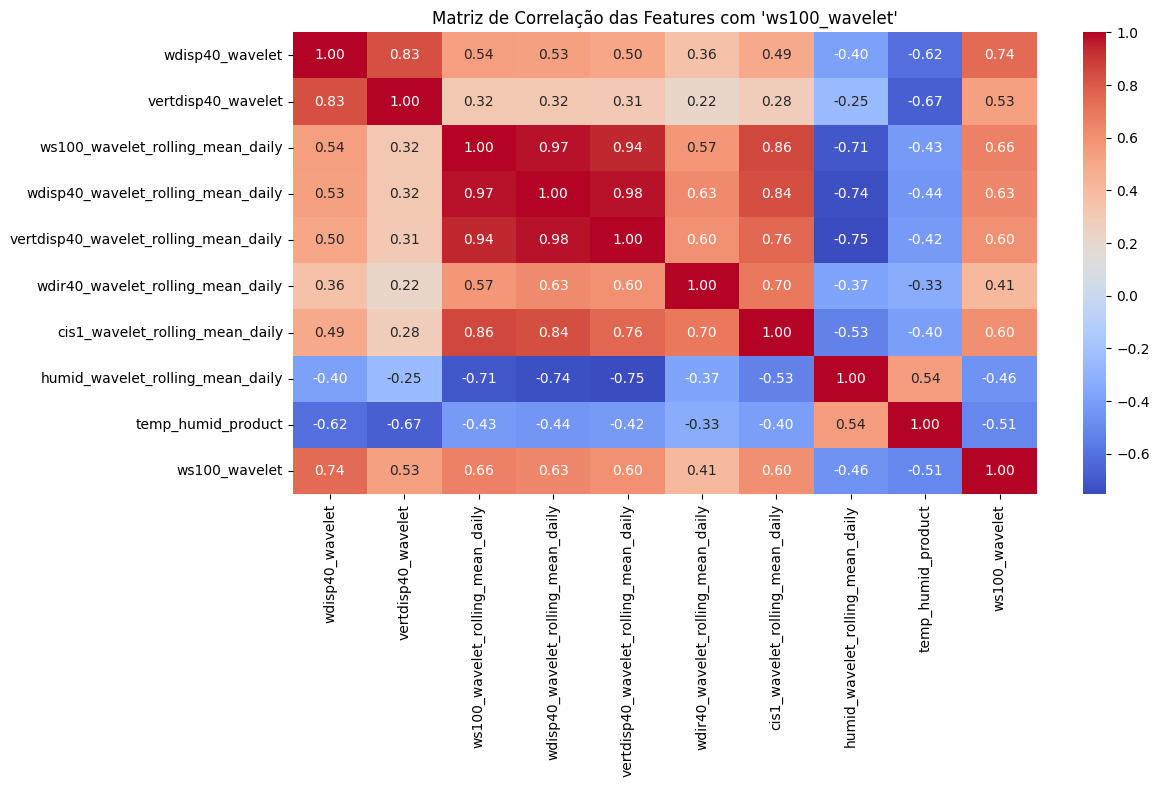

Dados processados com engenharia de features salvos em 'processed_variables_engineered.csv'.


In [35]:

# %%
# Cálculo da matriz de correlação
corr_matrix = variables_engineered.corr()

if 'ws100_wavelet' in corr_matrix.columns:
    ws100_corr = corr_matrix['ws100_wavelet']
    high_corr_features = ws100_corr[corr_matrix['ws100_wavelet'].abs() >= 1/np.e].drop('ws100_wavelet', errors='ignore')
else:
    raise ValueError("A coluna 'ws100_wavelet' não existe na matriz de correlação.")

print("\nFeatures com correlação >= 1/e (em valor absoluto) com 'ws100_wavelet':\n")
print(high_corr_features)

# Matriz de correlação das features selecionadas
high_corr_df = variables_engineered[high_corr_features.index.tolist() + ['ws100_wavelet']].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(high_corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Features com 'ws100_wavelet'")
plt.show()

variables_engineered = variables_engineered[high_corr_features.index.tolist() + ['ws100_wavelet']].copy()

# Salvando as variáveis processadas com as novas features
variables_engineered.to_csv('processed_variables_engineered.csv', index=True)
print("Dados processados com engenharia de features salvos em 'processed_variables_engineered.csv'.")


